<p class="float-right">![logo](https://github.com/mmattamala/LogosFCFM/blob/master/Ciencias%20de%20la%20Computaci%C3%B3n/Logos%20Facultad/fcfm_dcc_png.png?raw=true =300x)</p>

# Primera Entrega Proyecto

CC5113 - Aprendizaje Automático Bayesiano

Alumno: Cristian Tamblay

Profesor: Pablo Guerrero

Auxiliares: Joaquín Torres, Sergio Peñafiel

## Subir datos a Colaboratory

Agregar archivos en el input que aparece, luego muestra todos los archivos disponibles para ser usados

In [2]:
from google.colab import files
import os
files.upload()
!ls

Saving Datos.csv to Datos.csv
datalab  Datos.csv  sample_data


## Leer datos usando pandas

Se les hará una traslacion a los datos con el centro de santiago, para obtener un grafico mas visible.

Se asume que el centro de santiago es la interseccion entre la Alameda y la Ruta 5, coordenadas -33.446426, -70.660203

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
!pip install GPy

    100% |████████████████████████████████| 860kB 8.1MB/s 
    100% |████████████████████████████████| 71kB 18.6MB/s 
  Running setup.py bdist_wheel for GPy ... - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /content/.cache/pip/wheels/36/b9/13/498e283b6081c81aded82d1c174f8c251096027be686e79005
  Running setup.py bdist_wheel for paramz ... - done
  Stored in directory: /content/.cache/pip/wheels/5b/d6/3d/3ba4e455d8dfb30effec982d8a48668d1f2b16deb539554656
Successfully built GPy paramz


In [4]:
import pandas as pd
data = pd.read_csv("Datos.csv",sep=";",decimal=",")
data['Longitud'] = data['Longitud']+70.660203
data['Latitud'] = data['Latitud']+33.446426
data.head()

,Longitud,Latitud,Metros,Precio,Preciom2
0,-0.014976,0.016693,65.0,2600.0,40.000000
1,-0.004668,0.012184,64.0,2750.0,42.968750
2,0.023110,0.003494,160.0,7250.0,45.312500
3,0.010346,-0.019326,50.0,2390.0,47.800000
4,0.009843,0.008506,54.0,2600.0,48.148148


Ahora que tenemos cargados los datos, graficaremos algo para entender un poco lo que nos muestra el dataset.

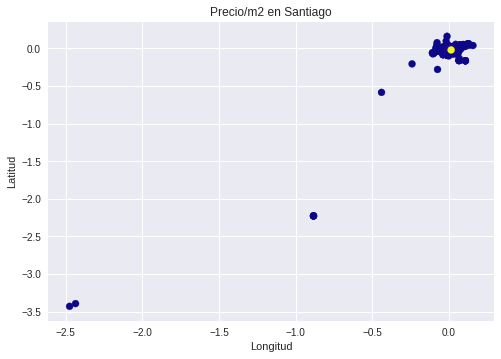

In [6]:
X = data.iloc[:,0]
Y = data.iloc[:,1]
color = data.iloc[:,4]
plt.scatter(x=X, y=Y, c=color, cmap='plasma')
plt.title(u"Precio/m2 en Santiago")
plt.xlabel(u"Longitud")
plt.ylabel(u"Latitud")
plt.show()


Este resultado nos muestra 2 cosas:

1) Hay datos que no estan dentro de Santiago (2 puntos de Longitud y 3 de Latitud es ENORME). Cada punto de latitud y longitud equivalen a 110 km aproximadamente.

2) Hay valores extremadamente altos, lo que hace que el resto sea muy pequeño, ya que todo es azul.


### Resolvamos 1)

0.2 grados en latitud equivalen a 22 km y sabemos que Santiago queda completamente incluido en un cuadrado de lado 44 km con centro en Alameda con Ruta 5

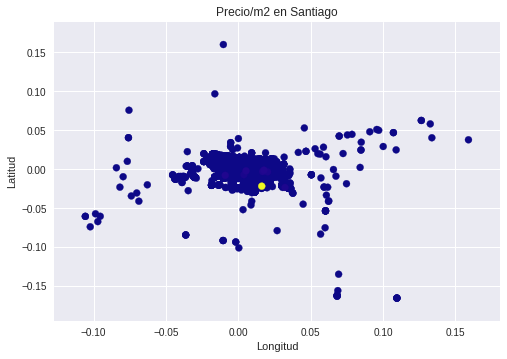

In [7]:
data = data[abs(data.Longitud)<=0.2]
data = data[abs(data.Latitud)<=0.2]
X = data.iloc[:,0]
Y = data.iloc[:,1]
color = data.iloc[:,4]
plt.scatter(x=X, y=Y, c=color, cmap='plasma')
plt.title(u"Precio/m2 en Santiago")
plt.xlabel(u"Longitud")
plt.ylabel(u"Latitud")
plt.show()

Con esto, la forma de Santiago es un poco mas clara.

### Resolvamos 2)

Usando algunos datos obtenidos rapidamente en google, podemos suponer que los precios mas baratos por m^2 rondan las 25 UF y los más altos las 150 UF. Agreguemos esta restricción.

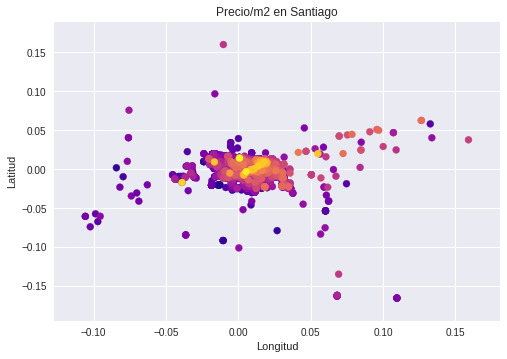

In [8]:
data = data[data.Preciom2>=675000]
data = data[data.Preciom2<=4050000]
color = data.iloc[:,4]
X = data.iloc[:,0]
Y = data.iloc[:,1]
plt.scatter(x=X, y=Y, c=color, cmap='plasma')
plt.title(u"Precio/m2 en Santiago")
plt.xlabel(u"Longitud")
plt.ylabel(u"Latitud")
plt.show()

Podemos finalmente hacer un zoom en Santiago centro, 0.04 grados en latitud equivalen a 4.4km.

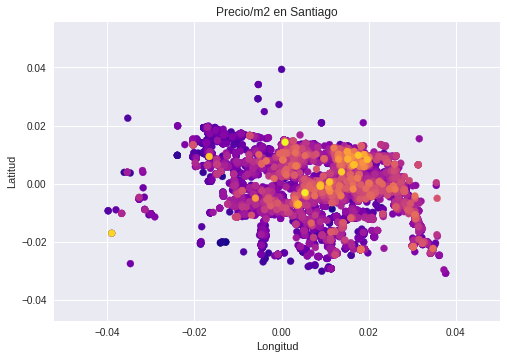

In [9]:
data = data[abs(data.Longitud)<=0.04]
data = data[abs(data.Latitud)<=0.04]
X = data.iloc[:,0]
Y = data.iloc[:,1]
color = data.iloc[:,4]
plt.scatter(x=X, y=Y, c=color, cmap='plasma')
plt.title(u"Precio/m2 en Santiago")
plt.xlabel(u"Longitud")
plt.ylabel(u"Latitud")
plt.show()

Por ultimo, visualizaremos los datos en 3D con plotly

In [10]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
plotly.tools.set_credentials_file(username='cristian.tamblay', api_key='OJwr2lNHDmoskz1vzRTb')

trace1 = go.Scatter3d(
    x=X,
    y=Y,
    z=color,
    mode='markers',
    marker=dict(
        size=12,
        color=color,                # set color to an array/list of desired values
        colorscale='Electric',   # choose a colorscale
        opacity=0.8
    )
)
trace = [trace1]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=trace, layout=layout)
py.iplot(fig, filename='3d-scatter-colorscale')

Con esto podemos notar que la varianza es muy grande

# Multi Layer Perceptron

Como los MLP están de moda primero probaremos con uno.

Separamos los datos de entrenamiento con los datos de test, como no tenemos muchos datos el tamaño del test será del 10% del tamaño total.

In [0]:
from sklearn.model_selection import train_test_split
x=data.iloc[:,0]
x=x.values.reshape(-1,1)
y=data.iloc[:,1]
y=y.values.reshape(-1,1)
z=data.iloc[:,4]
data_x, x_test, data_y, y_test, data_z, z_test = train_test_split(x, y, z, test_size=0.1)
data_inputs = np.concatenate((data_x, data_y), axis=1)
data_inputs_tests = np.concatenate((x_test, y_test), axis=1)

Primero intentaremos usar un MLP para hacer una regresión

In [12]:
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100,),max_iter=200)
mlp.fit(data_inputs,data_z)


/usr/local/lib/python2.7/dist-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Veamos el performance de esto, en terminos del error cuadratico medio

In [19]:
z_pred_mlp = mlp.predict(data_inputs_tests)
ecm_mlp = ((z_test - z_pred_mlp)**2).mean(axis=0)
print "ECM: %.2f" % ecm_mlp

ECM: 2267830322099.83


Este error es enorme, pero comprensible, ya que 1500 datos no bastan para entrenar una red neuronal. Como tenemos pocos datos, los procesos gaussianos serán más utíles.

# Procesos Gaussianos

### Primero con Kernel Ridge

Se utilizó primero Kernel Ridge para comparar con la red neuronal anterior.

In [15]:
from sklearn.kernel_ridge import KernelRidge
ker_regr_gauss = KernelRidge(kernel="rbf")
ker_regr_gauss.fit(data_inputs, data_z)

KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='rbf',
      kernel_params=None)

In [18]:
z_pred_ker = ker_regr_gauss.predict(data_inputs_tests)
ecm_ker = ((z_test - z_pred_ker)**2).mean(axis=0)
print "ECM: %.2f" % ecm_ker

ECM: 82655522966.12


Este error es grande, pero menor que el de la red neuronal.

### GPy

Debemos disminuir la cantidad de puntos, 1500 hace explotar a la cantidad de RAM necesaria. Se utilizaron 30% de los puntos iniciales, unos 300 puntos aproximadamente.

In [0]:
data_x2, x_test2, data_y2, y_test2, data_z2, z_test2 = train_test_split(data_x, data_y, data_z, test_size=0.7)

In [21]:
import GPy
X=data_x2.reshape(-1,1)
Y=data_y2.reshape(-1,1)
Z=data_z2.reshape(-1,1)
data_inputs = np.concatenate((X, Y), axis=1)
GPy.plotting.change_plotting_library('plotly')
m = GPy.models.GPRegression(data_inputs,Z)
m.optimize()
m

 /usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning:reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
 /usr/local/lib/python2.7/dist-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:overflow encountered in square


GP_regression.,value,constraints,priors
rbf.variance,965466589.9077506,+ve,
rbf.lengthscale,10317790.890547384,+ve,
Gaussian_noise.variance,4698529519.06681,+ve,


In [22]:
fig = m.plot()
GPy.plotting.show(fig)

This is the format of your plot grid:
[ (1,1) x1,y1 ]

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~cristian.tamblay/0 or inside your plot.ly account where it is named 'plot from API'


Este resultado nos dice que al centro hay un "punto caliente", pero tampoco es muy claro, ya que no se pueden apreciar diferencias en resto del plot. Mi hipotesis es que la solapacion de los datos confunde a GPy y su mejor apuesta es una prediccion constante, igual al promedio en todo el espacio.